## 日本語版
※ ここではGoogle Colaraboratoryでの実行を想定しています。

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/repos/deep-learning-with-pytorch-ja/p1ch7/

/content/drive/MyDrive/repos/deep-learning-with-pytorch-ja/p1ch7


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.cuda.get_device_name()

'Tesla K80'

In [9]:
torch.cuda.get_device_capability()

(3, 7)

In [10]:
tensor_sample = torch.Tensor([1, 2])
tensor_sample

tensor([1., 2.])

In [11]:
tensor_sample.device

device(type='cpu')

In [12]:
tensor_sample.to('cuda').device

device(type='cuda', index=0)

## 前項の前処理

In [13]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [14]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [15]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

## airplane と bird のみを抽出してモデリング

In [16]:
# ラベルの再定義
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

# （今回の場合は）
# __len__と__getitem__があれば良いのでDatasetオブジェクトではなくリストで対応可能
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [17]:
# 単純にモデルを組んでみる
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # 3 x 32 x 32
                512,   # 任意
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # 一つ前に出力層数
                n_out, # 2
            )
        )
# n_outには[0]と[1]それぞれに対するスコアがはいる

In [18]:
# softmax関数は各スコアのベクトルを確率に変換する機能を持つ
# exp()を用いるのはexp()が単調増加関数であり、正負に惑わされないためである
# 但し、これを「確率」とする妥当性については、必ずしも妥当とは言えない可能性がある。
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [19]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [20]:
softmax(x).sum()

tensor(1.)

In [21]:
# softmax関数はnnモジュールに用意されている
# 次元指定が必要
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [22]:
# softmaxを用いて確率を返すNNを再定義
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


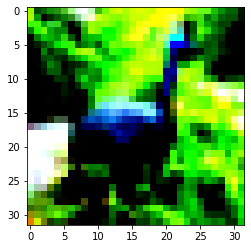

In [23]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [24]:
# 1枚入りのバッチを作成
img_batch = img.view(-1).unsqueeze(0) # 1次元化と次元の挿入
img_batch.shape

torch.Size([1, 3072])

In [25]:
# 未学習モデルで順伝播してみる
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [26]:
# torch.max(tensor, dim)で値とargmaxを取得。予測結果を得る
_, index = torch.max(out, dim=1)

index

tensor([1])

In [27]:
# デモンストレーション用Output。バッチサイズ４だとする
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

# 正解ラベルを準備。
truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [28]:
# MSEの場合
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [29]:
(out - truth) ** 2

tensor([[0.1600, 0.1600],
        [0.0100, 0.0100],
        [0.0900, 0.0900],
        [0.0400, 0.0400]])

In [30]:
# 正解ラベルの確率のみを抽出
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [31]:
# MSE修正
def mse(out):
    return ((1 - out.gather(dim=1, index=class_index)) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.0750)

''

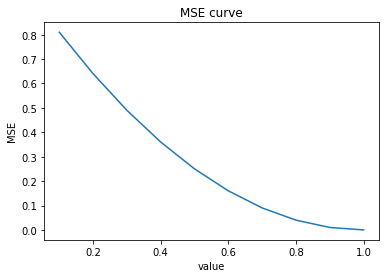

In [32]:
# MSEの見た目
samples = torch.Tensor([0.1 * (i+1) for i in range(10)])
plt.plot(samples, (1 - samples) ** 2)
plt.xlabel('value')
plt.ylabel('MSE')
plt.title('MSE curve')
;

In [33]:
# MSEではなく尤度損失関数を定義
# 各確度を掛け合わせる
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [34]:
# negative log likelihood
# 
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

''

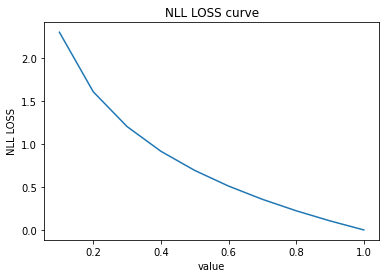

In [35]:
samples = torch.Tensor([0.1 * (i+1) for i in range(10)])
plt.plot(samples, -samples.log())
plt.xlabel('value')
plt.ylabel('NLL LOSS')
plt.title('NLL LOSS curve')
;

In [36]:
out.clone().detach()

tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])

In [37]:
# MSEの検証
# ズレの程度の違うoutputを準備して比べてみる。
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison
# ズレが大きいほどロスが大きい

tensor([0.0375, 0.0750, 0.1250, 0.2375])

In [38]:
# %diff
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [39]:
# NLLでもやってみる
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison
# 同様にずれに応じてロスが大きくなる

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [40]:
# %diff
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [41]:
# nn.NLLLossは対数確率のテンソルを受け取る
# そのため、Networkの最後はsoftmaxではなくLogSoftmaxを使う

In [42]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [43]:
# 検証：log(softmaxx(x))とlog_softmax(x)の違い
# 結果：log_softmax(x)は0入力に対して無限に飛ばないようになっているっぽい
x = torch.tensor([[0.0, 108.0]])

In [44]:
x

tensor([[  0., 108.]])

In [45]:
softmax(x)

tensor([[0., 1.]])

In [46]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [47]:
log_softmax(x)

tensor([[-108.,    0.]])

In [48]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [49]:
# LogSoftmaxを採用したモデル
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [50]:
# NLLLossを採用: 出力と正解ラベルインデックスを引数に取る
loss = nn.NLLLoss()

In [51]:
# モデルを走らせてみる

img, label = cifar2[0]
print(label)

out = model(img.view(-1).unsqueeze(0))
print(out)
print(torch.exp(out))
print(loss(out, torch.tensor([label])))

1
tensor([[-0.9211, -0.5077]], grad_fn=<LogSoftmaxBackward>)
tensor([[0.3981, 0.6019]], grad_fn=<ExpBackward>)
tensor(0.5077, grad_fn=<NllLossBackward>)


In [49]:
%%time

# NLLLossで学習してみる
# 一枚ずつ学習する場合

import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for img, label in cifar2:

        img_gpu = img.view(-1).unsqueeze(0).to('cuda')
        label_gpu = torch.tensor(label).unsqueeze(0).to('cuda')

        out = model(img_gpu)
        loss = loss_fn(out, label_gpu)


        optimizer.zero_grad()

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(label).float()) # predとラベルが一致した率を計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # 重みの更新

    running_loss /= len(cifar2) # 損失値の平均
    running_acc /= len(cifar2) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))



epoch: 0, loss: 1.0554666463463795, acc: 0.6886999607086182
epoch: 1, loss: 1.3657543937220882, acc: 0.6937999725341797
epoch: 2, loss: 1.3724240921941608, acc: 0.7027999758720398
epoch: 3, loss: 1.379102645198374, acc: 0.7055000066757202
epoch: 4, loss: 1.3483050211726102, acc: 0.7129999995231628
epoch: 5, loss: 1.3322341639684656, acc: 0.7177000045776367
epoch: 6, loss: 1.300853624408404, acc: 0.725600004196167
epoch: 7, loss: 1.3044334529327897, acc: 0.7253999710083008
epoch: 8, loss: 1.2696365531568983, acc: 0.7299999594688416
epoch: 9, loss: 1.274447246219178, acc: 0.7319999933242798
epoch: 10, loss: 1.2447657076541778, acc: 0.7425000071525574
epoch: 11, loss: 1.217543378085206, acc: 0.7487999796867371
epoch: 12, loss: 1.2282617680288832, acc: 0.7479000091552734
epoch: 13, loss: 1.1750577684916619, acc: 0.7554000020027161
epoch: 14, loss: 1.1629906759095883, acc: 0.7536999583244324
epoch: 15, loss: 1.1818556708497334, acc: 0.7554999589920044
epoch: 16, loss: 1.165250528347209, acc

''

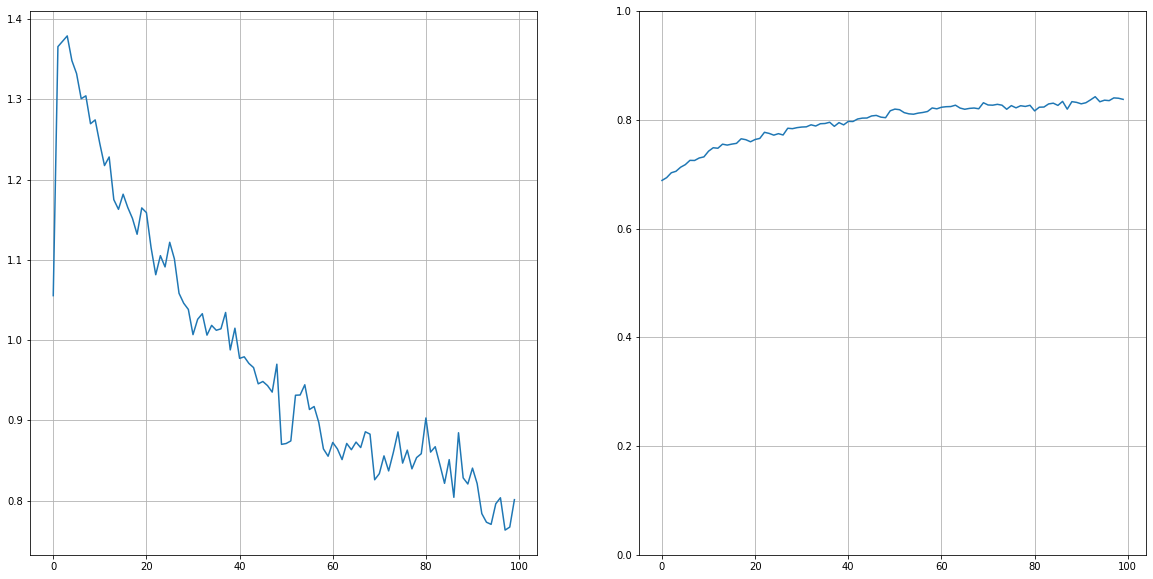

In [50]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [51]:
# DataLoaderを使う
# ミニバッチ作成
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [52]:
%%time
# DataLoaderでミニバッチ法を採用したモデル学習
# 高速且つ高精度
import torch
import torch.nn as nn
import torch.optim as optim

batch_size = 64
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_loader:

        imgs_gpu = imgs.view(imgs.shape[0], -1).to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')

        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        optimizer.zero_grad()

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # 重みの更新

    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 0.5020287682296364, acc: 0.765127420425415
epoch: 1, loss: 0.46298433432153835, acc: 0.7906051278114319
epoch: 2, loss: 0.4486563258869633, acc: 0.8012539744377136
epoch: 3, loss: 0.4350929920840415, acc: 0.8052349090576172
epoch: 4, loss: 0.42663423270936224, acc: 0.8108081221580505
epoch: 5, loss: 0.41478736964380664, acc: 0.8199641704559326
epoch: 6, loss: 0.40680986908590716, acc: 0.825039803981781
epoch: 7, loss: 0.3984639423478181, acc: 0.8270302414894104
epoch: 8, loss: 0.38820118442842155, acc: 0.8356887102127075
epoch: 9, loss: 0.38090037464336224, acc: 0.8381767868995667
epoch: 10, loss: 0.3745280985429788, acc: 0.8400676846504211
epoch: 11, loss: 0.3643182270276319, acc: 0.8460389971733093
epoch: 12, loss: 0.35837509222091385, acc: 0.8470342755317688
epoch: 13, loss: 0.3485703034575578, acc: 0.8555931448936462
epoch: 14, loss: 0.3394906061470129, acc: 0.858877420425415
epoch: 15, loss: 0.33237425403989806, acc: 0.8610668778419495
epoch: 16, loss: 0.3217713468

''

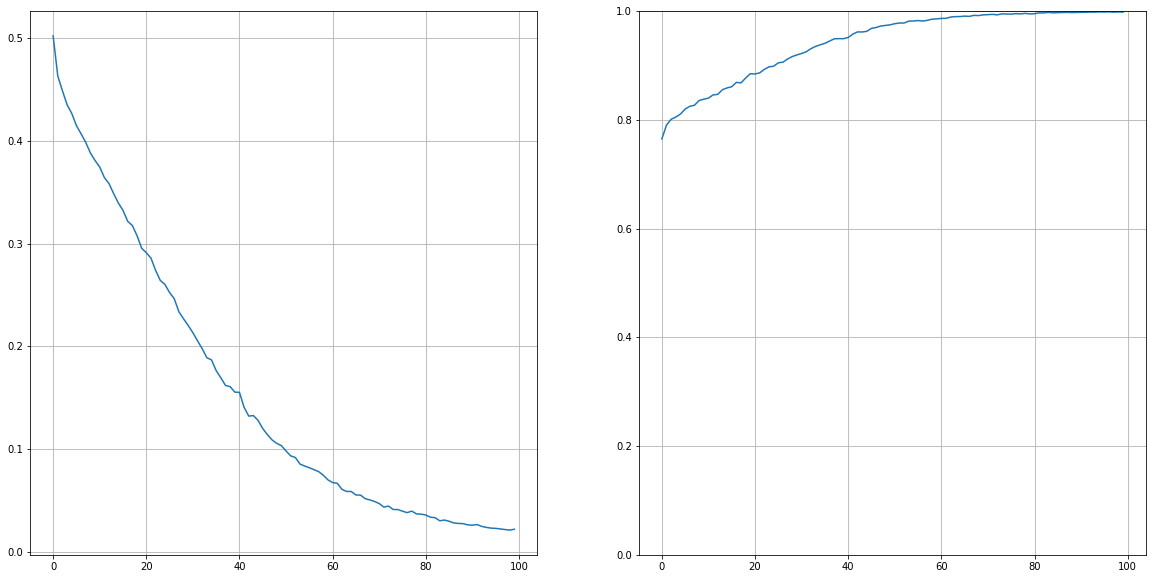

In [53]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [54]:
%%time

# 1層目の出力（2層目の入力）の数を 128 → 512
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):

    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_loader:

        imgs_gpu = imgs.view(imgs.shape[0], -1).to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')

        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算

        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 1.017665982246399, acc: 0.762042224407196
epoch: 1, loss: 0.933479368686676, acc: 0.7880175113677979
epoch: 2, loss: 0.8988736867904663, acc: 0.7958797812461853
epoch: 3, loss: 0.8698118329048157, acc: 0.8083201050758362
epoch: 4, loss: 0.8512380123138428, acc: 0.8142914175987244
epoch: 5, loss: 0.8309837579727173, acc: 0.8166799545288086
epoch: 6, loss: 0.8135880827903748, acc: 0.8254379034042358
epoch: 7, loss: 0.792569637298584, acc: 0.8287221193313599
epoch: 8, loss: 0.7762061953544617, acc: 0.8315087556838989
epoch: 9, loss: 0.7711830735206604, acc: 0.8349920511245728
epoch: 10, loss: 0.7469660639762878, acc: 0.8421576619148254
epoch: 11, loss: 0.7332887649536133, acc: 0.8429538607597351
epoch: 12, loss: 0.7160378098487854, acc: 0.8472332954406738
epoch: 13, loss: 0.7015784978866577, acc: 0.8505175113677979
epoch: 14, loss: 0.6790096759796143, acc: 0.8571855425834656
epoch: 15, loss: 0.6708673238754272, acc: 0.8618630766868591
epoch: 16, loss: 0.6484720706939697, a

''

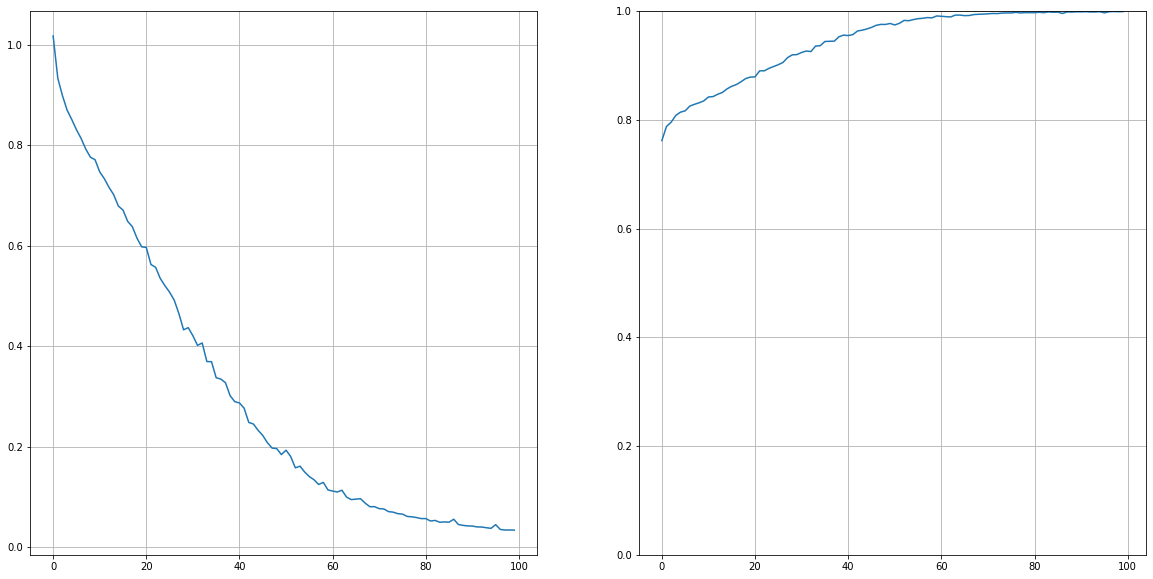

In [55]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [56]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999800


In [57]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.813500


In [58]:
# 階層を一つ深くした
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

loss_fn = nn.NLLLoss()

In [59]:
# 線形層出力 + nn.CrossEntropyLoss()  ==  LogSoftmax()出力 + nn.NLLLoss()
# 書き方が簡単になるが、softmax値である予測確率を取り出せなくなるため注意
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

model.to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

losses = []
accs = []

for epoch in range(n_epochs):
    
    running_loss = 0.0
    running_acc = 0.0
    
    for imgs, labels in train_loader:

        imgs_gpu = imgs.view(imgs.shape[0], -1).to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')


        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算

        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 1.0686873197555542, acc: 0.7522889971733093
epoch: 1, loss: 0.965146005153656, acc: 0.7865247130393982
epoch: 2, loss: 0.9313876628875732, acc: 0.7926951050758362
epoch: 3, loss: 0.9089221358299255, acc: 0.7974721193313599
epoch: 4, loss: 0.8867025375366211, acc: 0.8029458522796631
epoch: 5, loss: 0.8715624809265137, acc: 0.8067277073860168
epoch: 6, loss: 0.8502001166343689, acc: 0.8128980994224548
epoch: 7, loss: 0.8361421227455139, acc: 0.8161823153495789
epoch: 8, loss: 0.8215336799621582, acc: 0.8240445852279663
epoch: 9, loss: 0.8073435425758362, acc: 0.825039803981781
epoch: 10, loss: 0.7891348004341125, acc: 0.8296178579330444
epoch: 11, loss: 0.7760486006736755, acc: 0.8352906107902527
epoch: 12, loss: 0.7568254470825195, acc: 0.8366839289665222
epoch: 13, loss: 0.7413906455039978, acc: 0.8378781676292419
epoch: 14, loss: 0.7313490509986877, acc: 0.8429538607597351
epoch: 15, loss: 0.7196580767631531, acc: 0.8439490795135498
epoch: 16, loss: 0.7101576328277588,

''

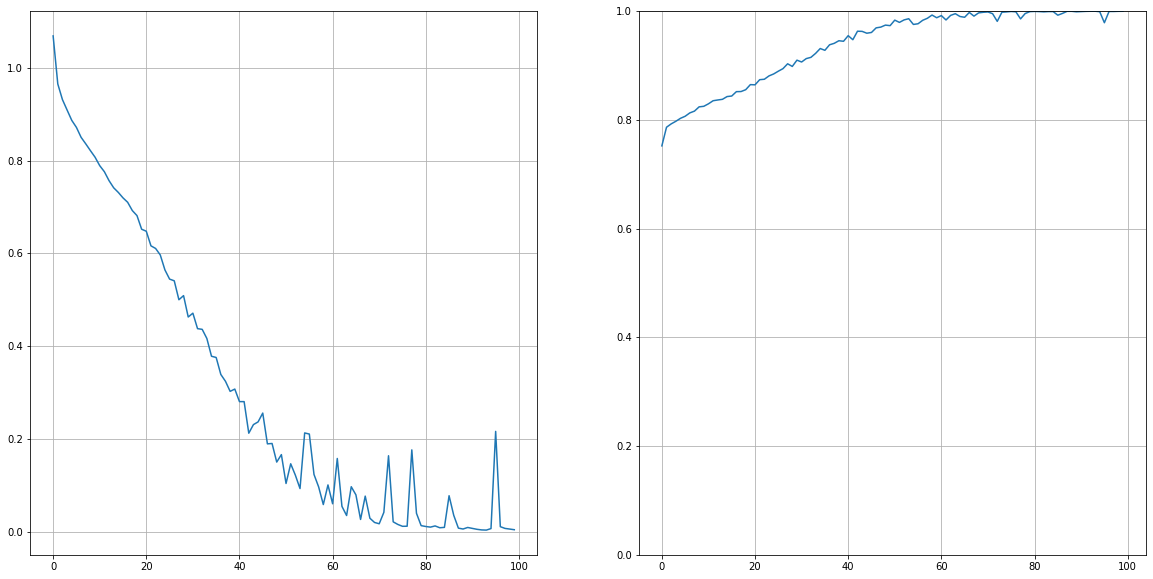

In [61]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].plot(losses)
ax[0].grid()
ax[1].plot(accs)
ax[1].grid()
ax[1].set_ylim([0,1])
;

In [62]:
# 訓練誤差は殆ど無し
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [63]:
# 検証誤差は結構ある
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.813500


In [64]:
# parameters()はlen()不可
len(model.parameters())

TypeError: ignored

In [65]:
# 直近モデルだと370万パラメータ
sum([p.numel() for p in model.parameters()])

3737474

In [66]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [67]:
# 最初のモデルだと150万パラメータ
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [68]:
# 最初の層がほとんどのパラメータ数を占める
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [69]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [70]:
# 1024 x 1024の画像などはGPUメモリ的にキツくなる
sum([p.numel() for p in nn.Linear(1024 * 1024, 1024).parameters()])

1073742848

In [71]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

# 畳込み

In [52]:
# nn.Conv2d: 畳込み層の定義。入力層、出力層、カーネルサイズ
# RGB入力の場合は入力３、出力任意
conv = nn.Conv2d(3, 16, kernel_size=3)

In [53]:
# カーネルサイズ（3x3）がin_channel数あり、それがout_channel数ある
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [54]:
conv.bias.shape

torch.Size([16])

In [55]:
# 初期パラメータでConv層を通してみる

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # 畳込み
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


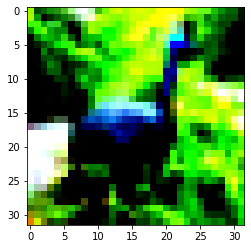

In [56]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

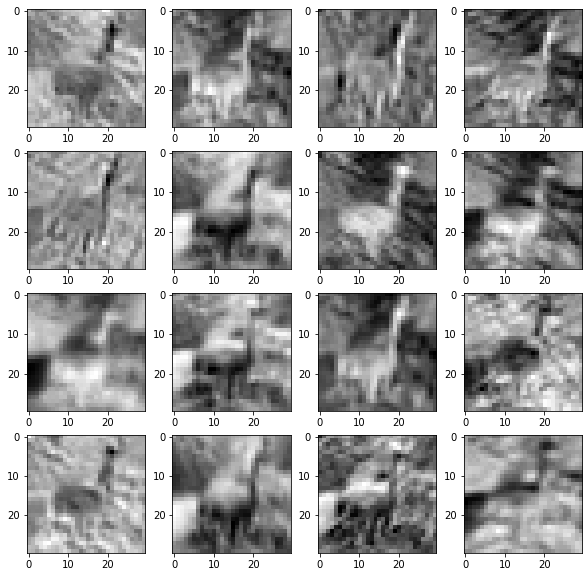

In [57]:
# カーネルを通過した16のout画像
nrows = 4
ncols = 4
fig, ax = plt.subplots(figsize=(10,10), nrows=nrows, ncols=ncols)
for i, im in enumerate(output[0].detach()):
    row = i // ncols
    col = i % ncols
    ax[row,col].imshow(im, 'gray')
# plt.imshow(output[0, 0].detach(), cmap='gray')
# plt.show()

In [58]:
output.shape

torch.Size([1, 16, 30, 30])

In [59]:
# 32 x 32 -> 30 x 30 になってしまっているのでpaddingを入れる
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [60]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

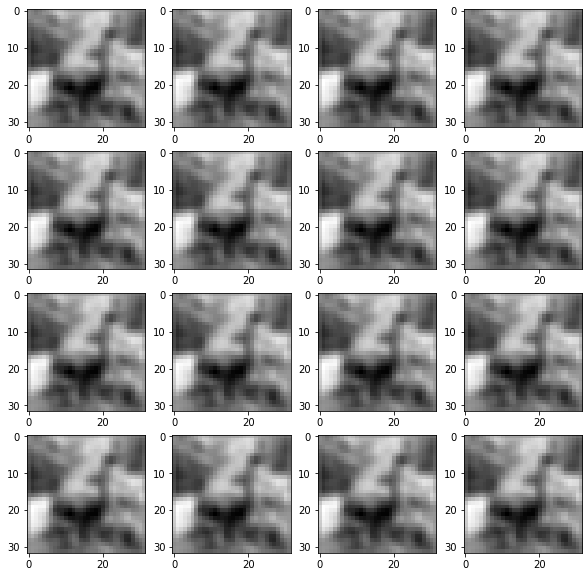

In [61]:
# 手動で全カーネル値が1/9のaverage filterにしてみる
conv2 = nn.Conv2d(3, 16, kernel_size=3, padding=1)

with torch.no_grad():
    conv2.bias.zero_()

with torch.no_grad():
    conv2.weight.fill_(1.0 / 9.0)

img, _ = cifar2[0]
output = conv2(img.unsqueeze(0))
nrows = 4
ncols = 4
fig, ax = plt.subplots(figsize=(10,10), nrows=nrows, ncols=ncols)
for i, im in enumerate(output[0].detach()):
    row = i // ncols
    col = i % ncols
    ax[row,col].imshow(im, 'gray')
# 全て同じ、average filterがかかった画像になる

In [62]:
# エッジフィルター
conv3 = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv3.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv3.bias.zero_()

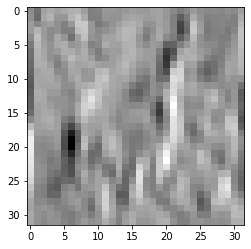

In [63]:
output = conv3(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [64]:
# pooling
pool = nn.MaxPool2d(2)

In [65]:
# pool層を通すとサイズが落ちる
output = pool(img.unsqueeze(0))
print(img.unsqueeze(0).shape)
print(output.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 16, 16])


In [66]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            #...
            )

In [67]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # WARNING: something missing here -> 線型化
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [68]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [69]:
# 線形層への入力が1次元のベクトルになっていないためエラー
model(img.unsqueeze(0))

RuntimeError: ignored

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # お決まり
        # モデルに使う層の定義
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # initで定義した層を並べて実行
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [71]:
model = Net()

sum([p.numel() for p in model.parameters()])

18090

In [72]:
# 上のモデルでは nn.Tanh(), nn.Maxpool2dをコンストラクタで定義して使用する際に無駄がある
# 以下のモデルでは nn.functional 内のTanhやMaxpoolを使用してよりコンパクトにしている
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [73]:
model = Net()
# model(data)でforwardメソッドが走るのは__call__で設定されているから。
# model.forward()では実行されないいろんなことも定義されているので__call__で使うのが正しい
model(img.unsqueeze(0))

tensor([[ 0.1955, -0.0078]], grad_fn=<AddmmBackward>)

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net().to('cuda')

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

# for epoch in range(n_epochs):
#     for imgs, labels in train_loader:
#         outputs = model(imgs)
#         loss = loss_fn(outputs, labels)
                
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


losses = []
accs = []

for epoch in range(n_epochs):
    
    running_loss = 0.0
    running_acc = 0.0
    
    for imgs, labels in train_loader:

        imgs_gpu = imgs.to('cuda')
        labels_gpu = torch.tensor(labels).to('cuda')

        out = model(imgs_gpu)
        loss = loss_fn(out, labels_gpu)

        running_loss += loss.item() # .item()で値を取り出してrunning_lossに足す
        pred = torch.argmax(out, dim=1) # outputには各分類ラベルに対するスコアが入っているだけの状態なので、最高スコアを取り出す。そのラベルが予測値となる。
        running_acc += torch.mean(pred.eq(labels_gpu).float()) # predとラベルが一致した率を計算

        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    running_loss /= len(train_loader) # 損失値の平均
    running_acc /= len(train_loader) # Accuracyの平均
    losses.append(running_loss) # このエポックでのロスをリストに追加
    accs.append(running_acc) # このエポックでのaccuracyをリストに追加
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss: 1.1798776388168335, acc: 0.7139729261398315
epoch: 1, loss: 0.9902640581130981, acc: 0.7801552414894104
epoch: 2, loss: 0.9036280512809753, acc: 0.8004578351974487
epoch: 3, loss: 0.8315061330795288, acc: 0.8176751732826233
epoch: 4, loss: 0.7829494476318359, acc: 0.827925980091095
epoch: 5, loss: 0.7537043690681458, acc: 0.8345939517021179
epoch: 6, loss: 0.7325631380081177, acc: 0.8412619829177856
epoch: 7, loss: 0.7109585404396057, acc: 0.8447452187538147
epoch: 8, loss: 0.7009090185165405, acc: 0.8479299545288086
epoch: 9, loss: 0.6840317249298096, acc: 0.8518112897872925
epoch: 10, loss: 0.6705229878425598, acc: 0.8521099090576172
epoch: 11, loss: 0.6561536192893982, acc: 0.8565883636474609
epoch: 12, loss: 0.6415141820907593, acc: 0.8630573153495789
epoch: 13, loss: 0.6322055459022522, acc: 0.8677349090576172
epoch: 14, loss: 0.629777193069458, acc: 0.8659434914588928
epoch: 15, loss: 0.6107017397880554, acc: 0.8713176846504211
epoch: 16, loss: 0.6031421422958374,

In [80]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.956300


In [81]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.to('cuda'))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels.to('cuda')).sum())
        
print("Accuracy: %f" % (correct / total))
# 精度向上を達成

Accuracy: 0.903000


In [83]:
# ReLU
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
sum([p.numel() for p in model.parameters()])

18090

In [ ]:
# ??
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))